In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import nan
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
plt.rcParams["font.size"] = "12"

In [3]:
def read_parameter_data(path,names):
    
    data = []
    for name in names:
        inputData = pd.read_csv("{}{}.csv".format(path,name),dtype=object)
        inputData.infer_objects()#convert_dtypes(convert_string=False)
   
        data.append(pd.DataFrame(inputData))
    return data    
def parse_parameter_data(names,data):
    returnData = []
    for name, algoData in zip(names,data):
        results_dict = algoData['results']
        params_dict = algoData['parameters']
        result_values = {}
        result_values["paramGroup"] = []
        
        for key in eval(params_dict.iloc[0]).keys():
            result_values[key]=[]
        
        
        for key in eval(results_dict.iloc[0]).keys():
            result_values[key] = []
        
        
        #generate_param_groups(params_dict)
        
        for resultRow in algoData.iterrows():
            
            
            
            rowParameters = eval(resultRow[1]['parameters'])
            
            rowResults = eval(resultRow[1]['results'])
            
            for listIndex in range(len(rowResults["fitness"])):
                for paramKey in rowParameters.keys():
                    result_values[paramKey].append(rowParameters[paramKey])
                    

                for resultKey in rowResults.keys():
                    
                    
                    result_values[resultKey].append(rowResults[resultKey][listIndex])
                    if type(rowResults[resultKey][listIndex]) == list:
                        finalKey = "{}_final".format(resultKey)

                        if not finalKey in result_values.keys():
                            result_values[finalKey] = []
                        if len(rowResults[resultKey][listIndex]) > 500:
                            result_values[finalKey].append(rowResults[resultKey][listIndex][49])
                        elif resultKey == "paths":
                            result_values[finalKey].append(rowResults[resultKey][listIndex])
                        
                        else:
                            result_values[finalKey].append(rowResults[resultKey][listIndex][-1])
                            
                            
                
        #print(result_values)
        returnData.append(pd.DataFrame(result_values))
        
        
        
    return returnData



def anova_plot(data,variable_field,between_fields,path=None,save=False):
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    tukey.plot_simultaneous(figsize=(15,15),ax=ax)
    ax.set_xlabel("Euclidean distance",fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title("")
    plt.show()
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
    return summary_df ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame.paramGroup == np.float(group))).dropna()],axis=0)
    return resultDF






In [4]:
names = ["SA_data","LS_data","GA_data","NSGA2_data","IBEA_data","IBEA_data_adaptive"]
dataPath = "../logs/UK50_1_Logs_2/"
dataset = "../datasets/UK50_1.txt"

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

plt.style.use("seaborn")

sa_data,ls_data,ga_data,nsga2_data,ibea_data,ibea_adaptive = parse_parameter_data(names,read_parameter_data(dataPath,names))
#sa_data,ls_data,ga_data,nsga2_data,ibea_data,nsga3_data,ibea_adaptive = parse_parameter_data(names,read_parameter_data(dataPath,names))


In [15]:
np.mean(ibea_10.fitness.to_numpy())

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [5]:
path = "../logs/UK50_1_Logs_2/"
nsga2_10,nsga3_10,ibea_10_adap,ibea_10,ga_data_10_pop = parse_parameter_data(["NSGA2_data_10_pop","NSGA3_data_10_pop_8_ref","IBEA_data_adaptive","IBEA_data_10_pop","GA_data_10_pop"],
                                                                read_parameter_data(path,["NSGA2_data_10_pop","NSGA3_data_10_pop_8_ref","IBEA_data_adaptive","IBEA_data_10_pop","GA_data_10_pop"]))

In [809]:

path = "../logs/UK20_1_Logs_Max_Drive_Time/"
nsga3_maxDriveTime=parse_parameter_data(["NSGA2_data"],read_parameter_data(path,["NSGA2_data"]))[0]

In [8]:
nsga3_data = read_parameter_data(dataPath,["NSGA3_data_restored"])[0]
for col in ["maxDriveTimes_final","mutation","fuel_consumption_final","optimal_time","fuel_consumption","IGD","fitness","paths_final","IGD_final","paramGroup","fitness_final","violation","maxDriveTimes"]:
    nsga3_data[col] = nsga3_data[col].apply(eval)

# Anova plot for parameters of SA

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


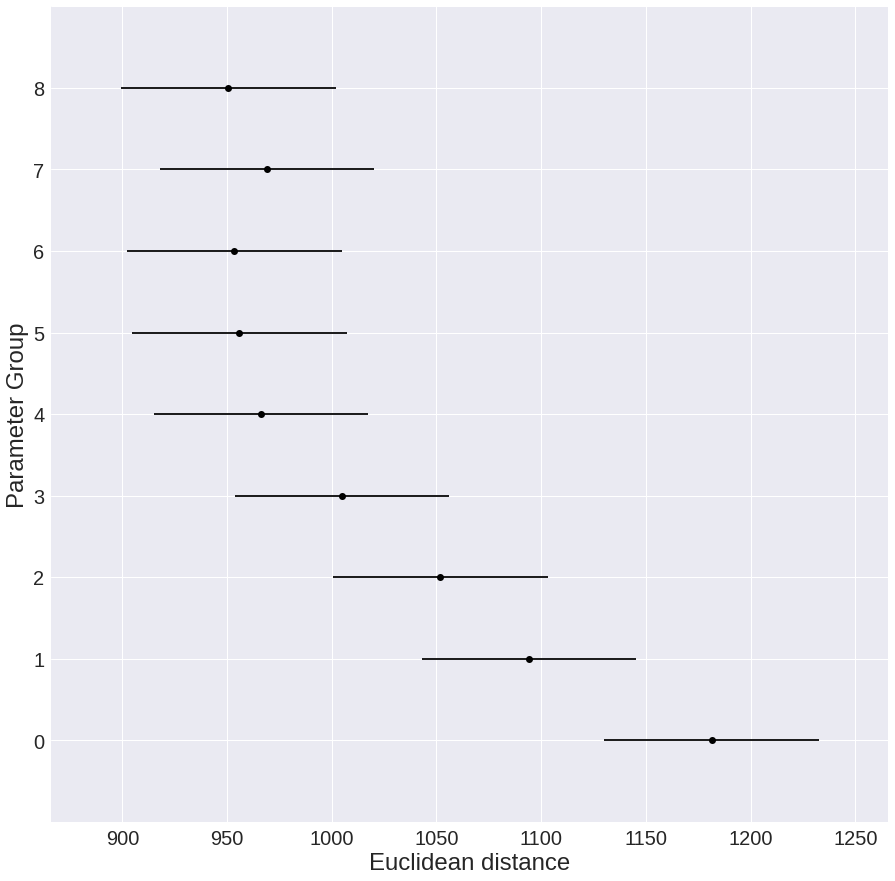

Optimal Parameters: Mutation 0.9 ParamGroup 8


In [9]:
sa_data_tukey,fig,t = anova_plot(sa_data,'IGD_final','paramGroup')
sa_data_optimal = extractOptimalParameters(sa_data,sa_data_tukey,1)
sa_data_optimal.algoritm = "SA"
print("Optimal Parameters: Mutation {} ParamGroup {}".format(sa_data_optimal.iloc[0].mutation,int(sa_data_optimal.iloc[0].paramGroup)))
# Bigger exploration neighborhood -> better solutions

# Anova plot for Local Search parameters

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


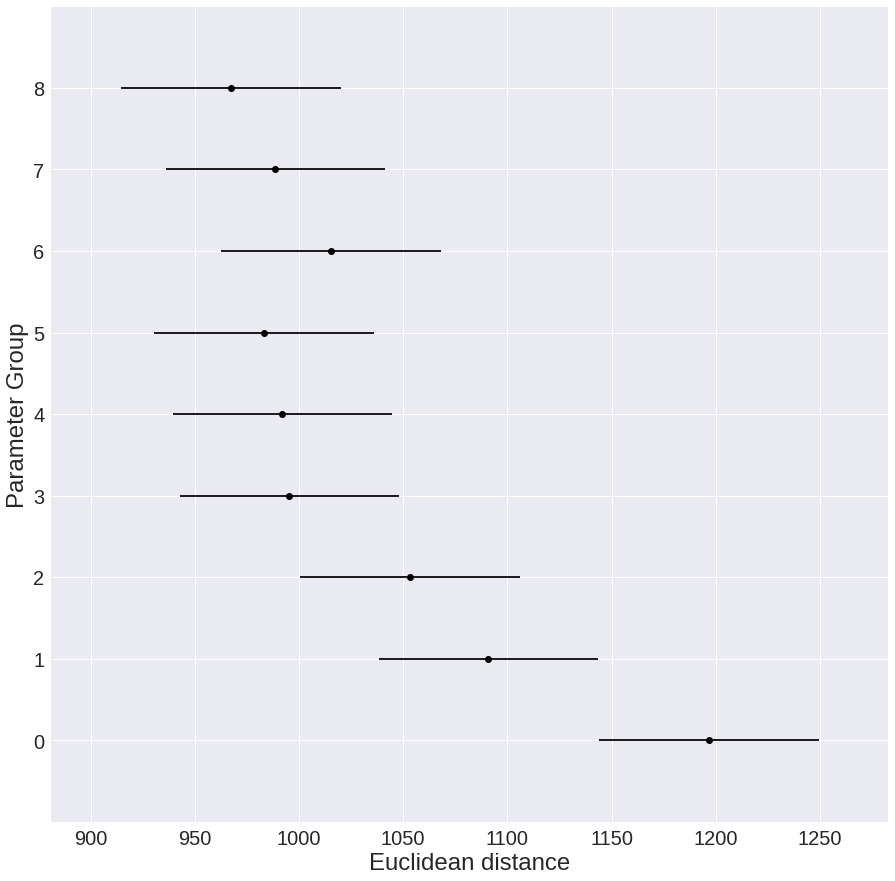

Optimal Parameters: Mutation 0.9


In [10]:
ls_data_tukey,fig,_ = anova_plot(ls_data,'IGD_final','paramGroup')
ls_data_optimal = extractOptimalParameters(ls_data,ls_data_tukey,1)
ls_data_optimal.algoritm = "LS"
print("Optimal Parameters: Mutation {}".format(ls_data_optimal.iloc[0].mutation))
# Bigger exploration neighborhood -> better solutions

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


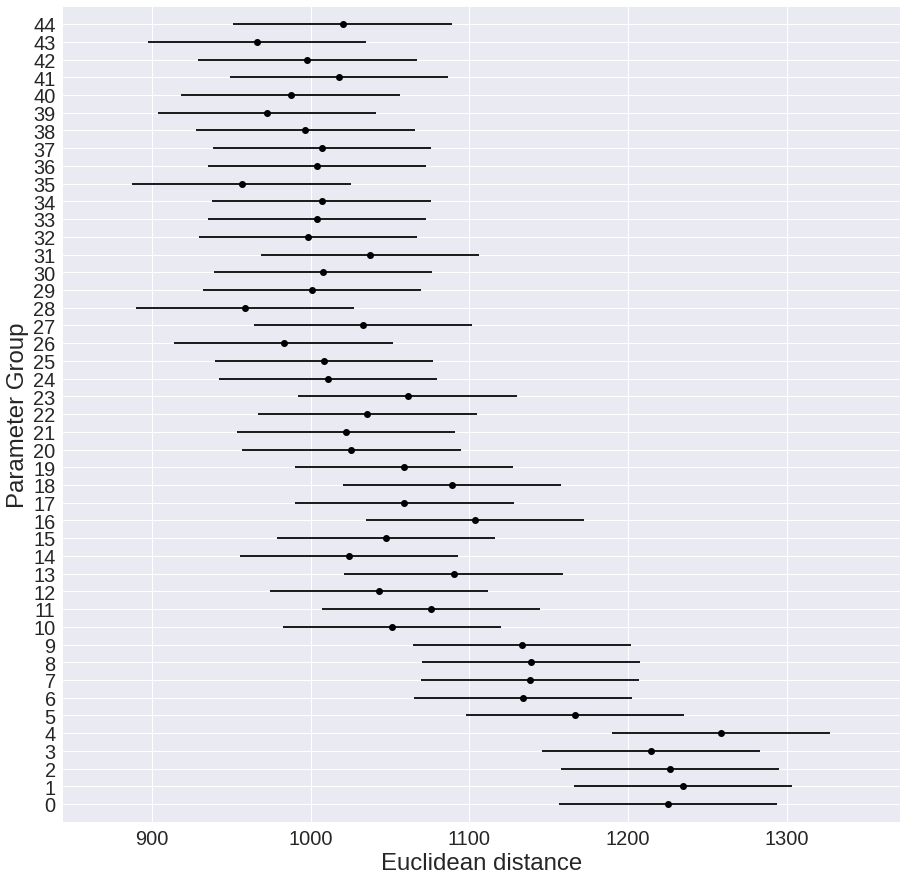

Optimal Parameters: Mutation 0.8 Crossover 0.2 ParamGroup: 35.0


In [11]:
nsga3_data_tukey,fig,_ = anova_plot(nsga3_data,'IGD_final','paramGroup')
nsga3_data_optimal = extractOptimalParameters(nsga3_data,nsga3_data_tukey,1)
nsga3_data_optimal.algorithm = "NSGA-III"
print("Optimal Parameters: Mutation {} Crossover {} ParamGroup: {}".format(nsga3_data_optimal.iloc[0].mutation,nsga3_data_optimal.iloc[0].crossover,nsga3_data_optimal.iloc[0].paramGroup))
# Bigger exploration neighborhood -> better solutions

In [56]:
nsga3_maxDriveTime_tukey,_,_ = anova_plot(nsga3_maxDriveTime,'IGD_final','paramGroup')
nsga3_maxDriveTime_optimal = extractOptimalParameters(nsga3_maxDriveTime,nsga3_maxDriveTime_tukey,1)
nsga3_maxDriveTime_optimal.algorithm = "NSGA-III"
print("Optimal Parameters: Mutation {} Crossover {}".format(nsga3_maxDriveTime_optimal.iloc[0].mutation,nsga3_maxDriveTime_optimal.iloc[0].crossover))
# Bigger exploration neighborhood -> better solutions

NameError: name 'nsga3_maxDriveTime' is not defined

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


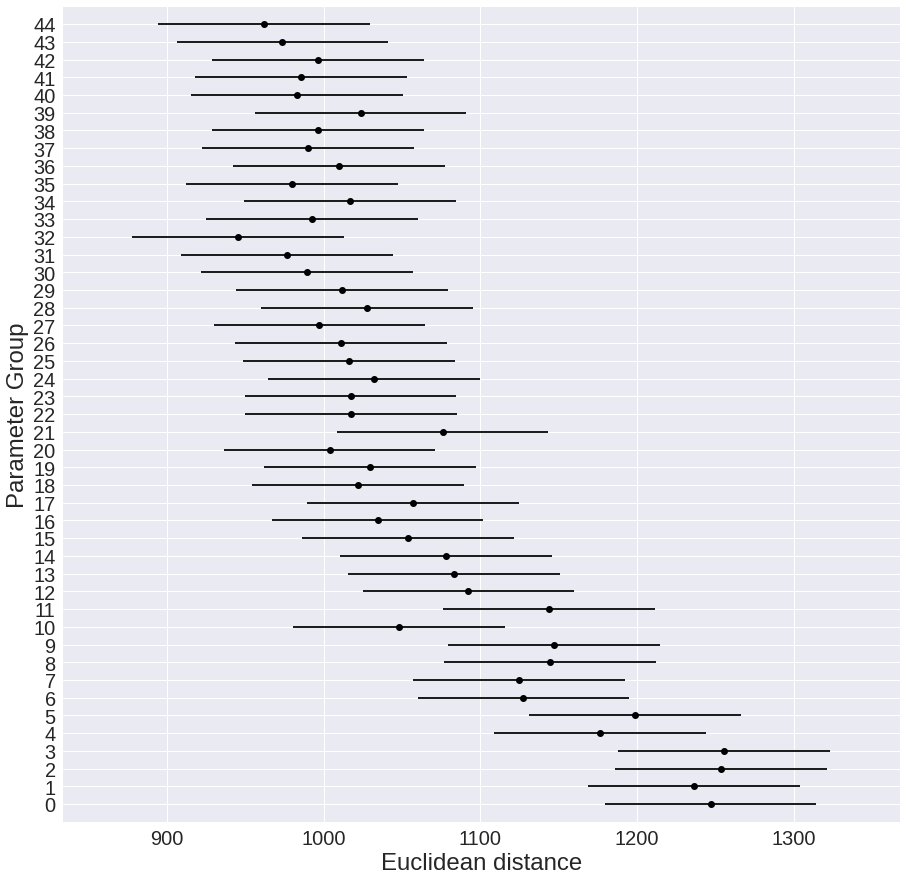

Optimal Parameters: Mutation 0.7 Crossover 0.5 ParamGroup 32.0


In [12]:
nsga2_data_tukey,fig,_ = anova_plot(nsga2_data,'IGD_final','paramGroup')
nsga2_data_optimal = extractOptimalParameters(nsga2_data,nsga2_data_tukey,1)
print("Optimal Parameters: Mutation {} Crossover {} ParamGroup {}".format(nsga2_data_optimal.iloc[0].mutation,nsga2_data_optimal.iloc[0].crossover,nsga2_data_optimal.iloc[0].paramGroup))
nsga2_data_optimal.algorithm="NSGA-II"

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


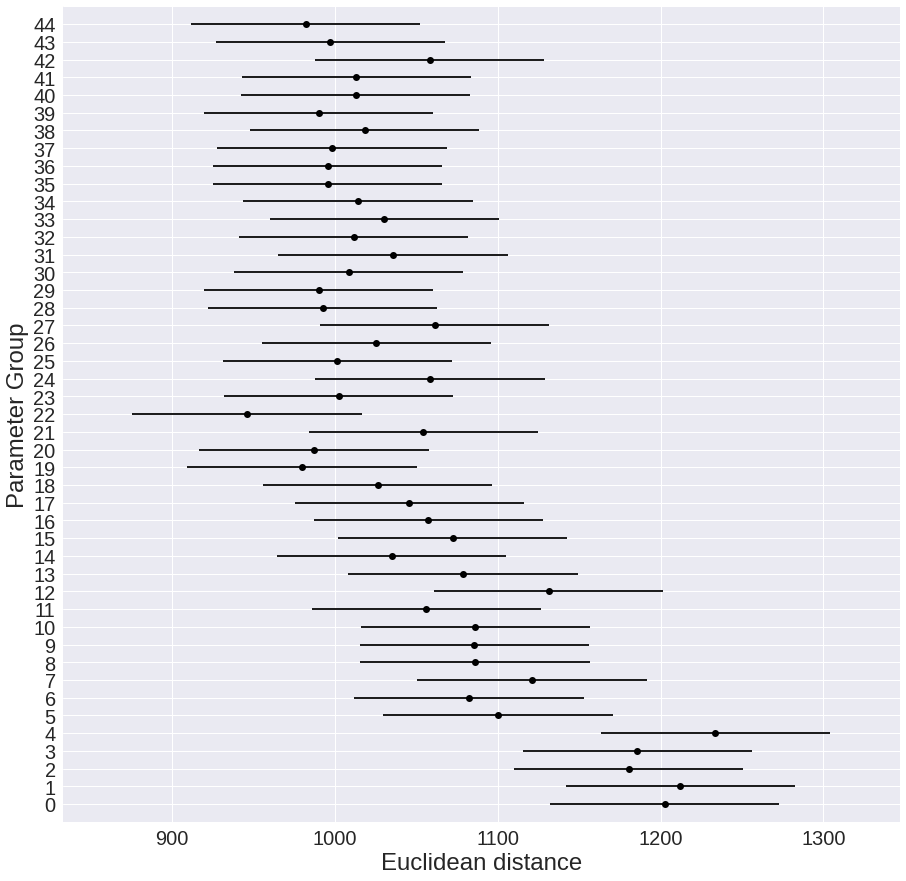

Optimal Parameters: Mutation 0.5 Crossover 0.5 ParamGroup 22.0


In [13]:
ga_data_tukey,fig,_ = anova_plot(ga_data,'IGD_final','paramGroup')
ga_data_optimal = extractOptimalParameters(ga_data,ga_data_tukey,1)
print("Optimal Parameters: Mutation {} Crossover {} ParamGroup {}".format(ga_data_optimal.iloc[0].mutation,ga_data_optimal.iloc[0].crossover,ga_data_optimal.iloc[0].paramGroup))
ga_data_optimal.algorithm = "GA"
# Bigger exploration neighborhood -> better solutionsga_no_reset

In [ ]:
display(anova_test(hype_no_reset,'maxDriveTimes_final','mutation'))
display(anova_test(hype_no_reset,'fuel_consumption_final','paramGroup'))
display(anova_test(hype_no_reset,'IGD_final','paramGroup'))
hype_no_resettukey = anova_plot(hype_no_reset,'IGD_final','paramGroup')
hype_no_resetoptimal = extractOptimalParameters(hype_no_reset,hype_no_resettukey,1)#ibea_no_reset
hype_no_resetoptimal.algoritm = "HYPE_SINGLE_NO_RESET"
# Bigger exploration neighborhood -> better solutions

In [14]:
ibea_data_scalar_tukey = anova_plot(ibea_data_scalar,'IGD_final','paramGroup')
ibea_data_scalar_optimal = extractOptimalParameters(ibea_data_scalar,ibea_data_scalar_tukey,1)
ibea_data_scalar_optimal.algorithm = "IBEA_Constraint_Scalar"
print("Optimal Parameters: Mutation {} Crossover {}".format(ibea_data_scalar_optimal.iloc[0].mutation,ibea_data_scalar_optimal.iloc[0].crossover))
# Bigger exploration neighborhood -> better solutions

NameError: name 'ibea_data_scalar' is not defined

In [82]:
ibea_data_optimal_violated = ibea_data_optimal.where(ibea_data_optimal.violation_final != 0)
ibea_data_optimal_violated.dropna(inplace=True)
ibea_data_optimal_violated.describe()

,paramGroup,mutation,crossover,optimal_time,fuel_consumption_final,maxDriveTimes_final,violation_final,IGD_final
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# ibea_data_scalar_optimal_violated = ibea_data_scalar_optimal.where(ibea_data_scalar_optimal.violation_final != 0)
# ibea_data_scalar_optimal_violated.dropna(inplace=True)
# ibea_data_scalar_optimal_violated.describe()

,paramGroup,mutation,crossover,optimal_time,fuel_consumption_final,maxDriveTimes_final,violation_final,IGD_final
count,3.0,3.0,3.00,3.000000,3.000000,3.000000,3.000000,3.000000
mean,43.0,0.9,0.65,1.999868,163.217425,26073.666667,-873.666667,1038.961883
std,0.0,0.0,0.00,0.271670,10.210669,783.179630,783.179630,39.460055
min,43.0,0.9,0.65,1.781431,153.977935,25310.000000,-1675.000000,993.735147
25%,43.0,0.9,0.65,1.847767,157.736133,25673.000000,-1255.500000,1025.257144
50%,43.0,0.9,0.65,1.914102,161.494331,26036.000000,-836.000000,1056.779141
75%,43.0,0.9,0.65,2.109086,167.837171,26455.500000,-473.000000,1061.575251
max,43.0,0.9,0.65,2.304070,174.180010,26875.000000,-110.000000,1066.371361


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


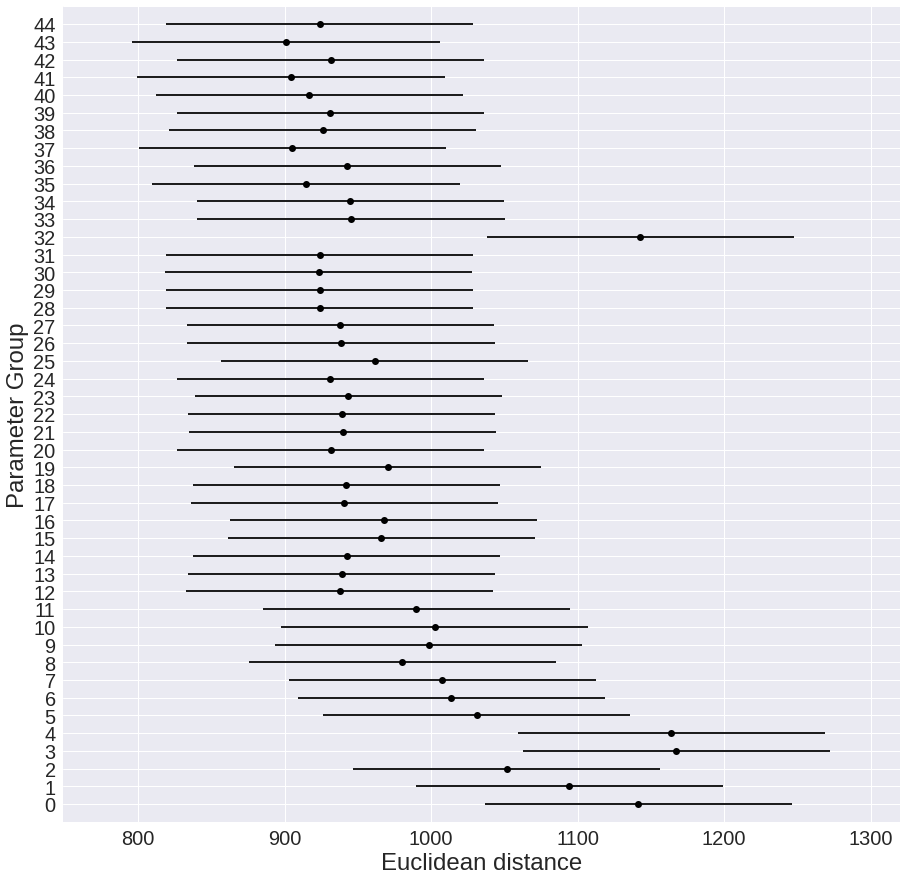

Optimal Parameters: Mutation 0.9 Crossover 0.65 ParamGroup 43.0


In [15]:
ibea_data_tukey,fig,_ = anova_plot(ibea_data,'IGD_final','paramGroup')
ibea_data_optimal = extractOptimalParameters(ibea_data,ibea_data_tukey,1)
ibea_data_optimal.algorithm = "IBEA"
print("Optimal Parameters: Mutation {} Crossover {} ParamGroup {}".format(ibea_data_optimal.iloc[0].mutation,ibea_data_optimal.iloc[0].crossover,ibea_data_optimal.iloc[0].paramGroup))
# Bigger exploration neighborhood -> better solutions

In [175]:
ibea_adaptive

,paramGroup,mutation,crossover,algorithm,fitness,fuel_consumption,optimal_time,maxDriveTimes,violation,paths,IGD,fitness_final,fuel_consumption_final,maxDriveTimes_final,violation_final,paths_final,IGD_final
0,0,0.8,0.65,IBEA,"[[280.6543262013795, 1493.8666666666666], [326...","[280.6543262013795, 326.0751627482876, 282.164...",6.094422,"[35671, 34636, 32052, 29350, 29258, 25947, 259...","[-10941, -9436, -6852, -4150, -4058, -747, -74...","[[6, 1, 11, 12, 14, 16, 7, 19, 5], [15, 3, 18,...","[1520.0014699313049, 1728.6489981212976, 1549....","[147.49827937377307, 924.5166666666667]",147.498279,24028,0,"[[6, 1, 11, 12, 14, 16, 7, 19, 5], [15, 3, 18,...",936.208742


ValueError: 2 or more groups required for multiple comparisons

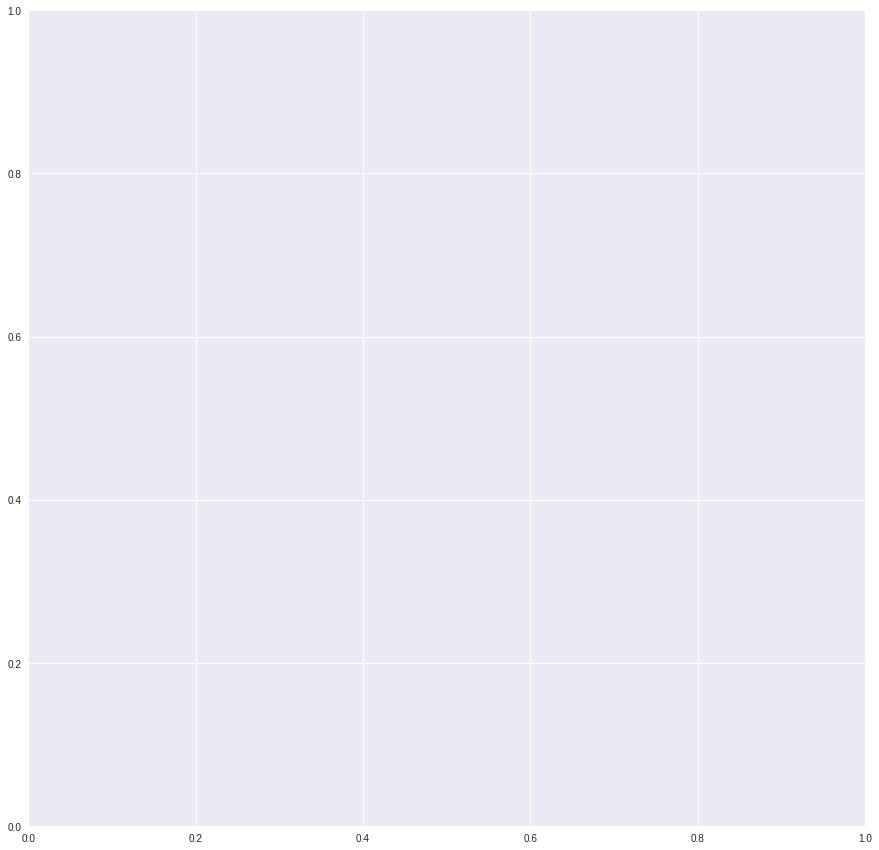

In [16]:
ibea_adaptive_data_tukey,_,_ = anova_plot(ibea_adaptive,'IGD_final','paramGroup')
ibea_adaptive_data_optimal = extractOptimalParameters(ibea_adaptive,ibea_adaptive_data_tukey,1)
ibea_adaptive_data_optimal.algorithm = "IBEA Adaptive"
print("Optimal Parameters: Mutation {} Crossover {}".format(ibea_adaptive_data_optimal.iloc[0].mutation,ibea_adaptive_data_optimal.iloc[0].crossover))
# Bigger exploration neighborhood -> better solutions

In [17]:
fitness_values_ibea = [ np.array(f) for f in ibea_data_optimal.fuel_consumption ]
fitness_values_ibea_adaptive = [ np.array(f) for f in ibea_adaptive.fuel_consumption ]
fitness_values_sa = [np.array(f) for f in sa_data_optimal.fuel_consumption]
fitness_values_ga = [np.array(f) for f in ga_data_optimal.fuel_consumption]
fitness_values_nsga2 = [np.array(f) for f in nsga2_data_optimal.fuel_consumption]
fitness_values_nsga3 = [np.array(f) for f in nsga3_data_optimal.fuel_consumption]
fitness_values_ls = [np.array(f) for f in ls_data_optimal.fuel_consumption]

In [18]:
fitness_values_ibea_adaptive = [ np.array(f)[:,0] for f in ibea_10_adap.fitness ]

NameError: name 'ibea_10_adap' is not defined

In [46]:
len(nsga3_10.fuel_consumption[0])

100

In [18]:

def getTotalDriveTimesFromPaths2(paths,timeMatrix):
    driveTimes = []
    
    #for path in paths:
    driveTime = 0
    for route in paths:
        for index in range(len(route)-1):
            driveTime += timeMatrix.iloc[route[index]][route[index+1]]

    driveTimes.append(driveTime/60)

    return driveTimes
def calc_drive_time_for_singleobj(row):
    #print(row)
    fitness_list = row["fitness"]
    violation_list = row["violation"]
    fuel_consumption_list = row["fuel_consumption"]
    
    driveTimes = []
    for fitness,violation,fuel in zip(fitness_list,violation_list,fuel_consumption_list):
        if row["algorithm"] != "LS":
            driveTimes.append(fitness + violation - fuel)
        else:
            driveTimes.append(fitness  - fuel)
    return driveTimes
    #print(fitness_list)
    #sa_data_optimal.fitness.iloc[0][0] - sa_data_optimal.violation.iloc[0][0] - sa_data_optimal.fuel_consumption.iloc[0][0]
    #for



drive_times_ibea =  [np.array(f)[:,1] for f in ibea_data.fitness]#getTotalDriveTimesFromPaths( ibea_data_optimal.paths,time_matrix_here)
drive_times_nsga2 = [np.array(f)[:,1] for f in nsga2_data.fitness]
drive_times_nsga3 = [np.array(f)[:,1] for f in nsga3_data.fitness]
drive_times_sa = [calc_drive_time_for_singleobj(f) for x,f in sa_data.iterrows()]
drive_times_ls = [calc_drive_time_for_singleobj(f) for x,f in ls_data.iterrows()]
drive_times_ga = [calc_drive_time_for_singleobj(f) for x,f in ga_data.iterrows()]

1.1635791053467912


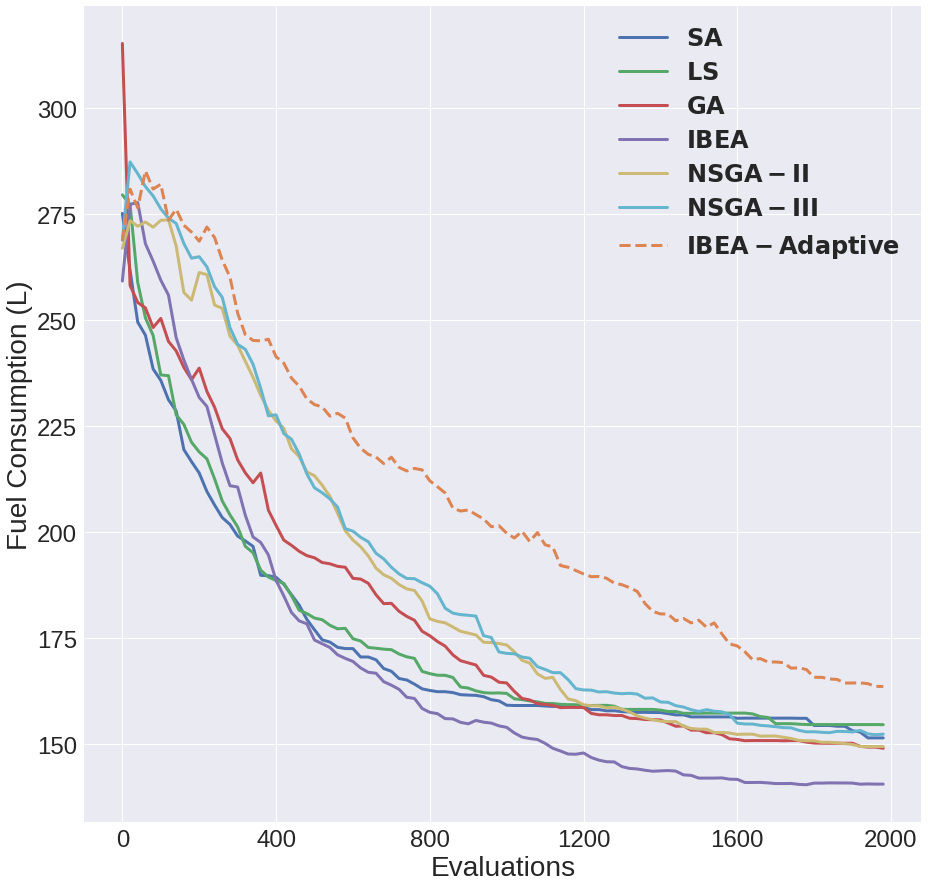

In [20]:
import seaborn as sns
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.style.use("seaborn")
#legend_properties = {'weight':'bold','size':20}

plt.plot(np.mean(fitness_values_sa,axis=0),linewidth=3,label = r"$\bf{SA}$")
plt.plot(np.mean(fitness_values_ls,axis=0),linewidth=3,label = r"$\bf{LS}$")
plt.plot(np.mean(fitness_values_ga,axis=0),linewidth=3,label = r"$\bf{GA}$")
plt.plot(np.mean(fitness_values_ibea,axis=0) ,linewidth=3 ,label= r"$\bf{IBEA}$")
plt.plot(np.mean(fitness_values_nsga2,axis=0),linewidth=3,label = r"$\bf{NSGA-II}$")
plt.plot(np.mean(fitness_values_nsga3,axis=0),linewidth=3,label = r"$\bf{NSGA-III}$")
plt.plot(np.mean(fitness_values_ibea_adaptive,axis=0) ,linewidth=3 ,linestyle="--",color=sns.color_palette("deep",10)[1],label= r"$\bf{IBEA-Adaptive}$")
plt.xlabel("Evaluations",fontsize=28)
plt.xticks(range(0,120,20),range(0,2400,400))
plt.ylabel("Fuel Consumption (L)",fontsize=28)
plt.legend(fontsize=24)#,prop= legend_properties)
#plt.ylim(top=700)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
#print()
print(np.mean(fitness_values_ibea_adaptive,axis=0)[-1]/np.mean(fitness_values_ibea,axis=0)[-1])
plt.show()

In [21]:
fig.savefig("{}/fuel_consumption_UK20_1_adaptive_fixed.pdf".format(dataPath))

NameError: name 'drive_times_sa' is not defined

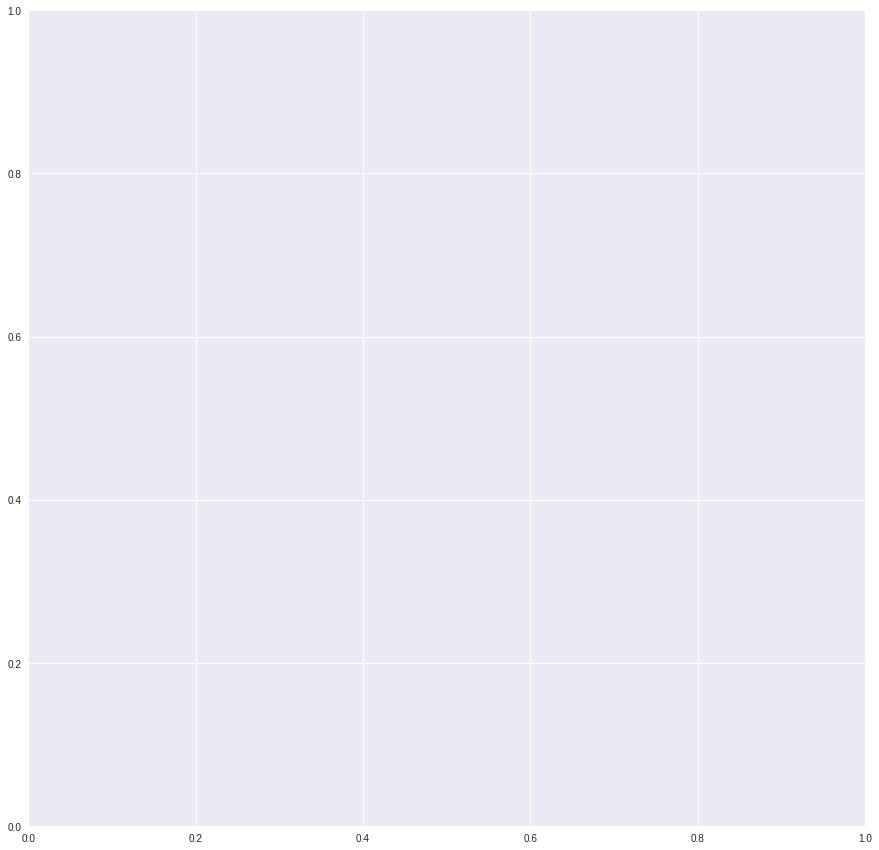

In [40]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.style.use("seaborn")
#legend_properties = {'weight':'bold','size':20}

plt.plot(np.mean(drive_times_sa,axis=0),linewidth=3,label = r"$\bf{SA}$")
plt.plot(np.mean(drive_times_ls,axis=0),linewidth=3,label = r"$\bf{LS}$")
plt.plot(np.mean(drive_times_ga,axis=0),linewidth=3,label = r"$\bf{GA}$")
plt.plot(np.mean(drive_times_ibea,axis=0) ,linewidth=3 ,label= r"$\bf{IBEA}$")
plt.plot(np.mean(drive_times_nsga2,axis=0),linewidth=3,label = r"$\bf{NSGA-II}$")
plt.plot(np.mean(drive_times_nsga3,axis=0),linewidth=3,label = r"$\bf{NSGA-III}$")
plt.xlabel("Iterations",fontsize=24)
plt.xticks(range(0,120,20),range(0,6000,1000))
plt.ylabel("Total Drive Time (Minutes)",fontsize=24)
plt.legend(fontsize=20)#,prop= legend_properties)
#plt.ylim(top=700)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


plt.show()

In [303]:
fig.savefig("{}/drive_time_curve_UK50_2.pdf".format(dataPath))

In [10]:
fitness_values_ibea = [ np.array(f) for f in ibea_data_optimal.fuel_consumption ]
fitness_values_sa = [np.array(f) for f in sa_data_optimal.fuel_consumption]
fitness_values_ga = [np.array(f) for f in ga_data_optimal.fuel_consumption]
fitness_values_nsga2 = [np.array(f) for f in nsga2_data_optimal.fuel_consumption]
fitness_values_nsga3 = [np.array(f) for f in nsga3_data_optimal.fuel_consumption]
fitness_values_ls = [np.array(f) for f in ls_data_optimal.fuel_consumption]

NameError: name 'ibea_data_optimal' is not defined

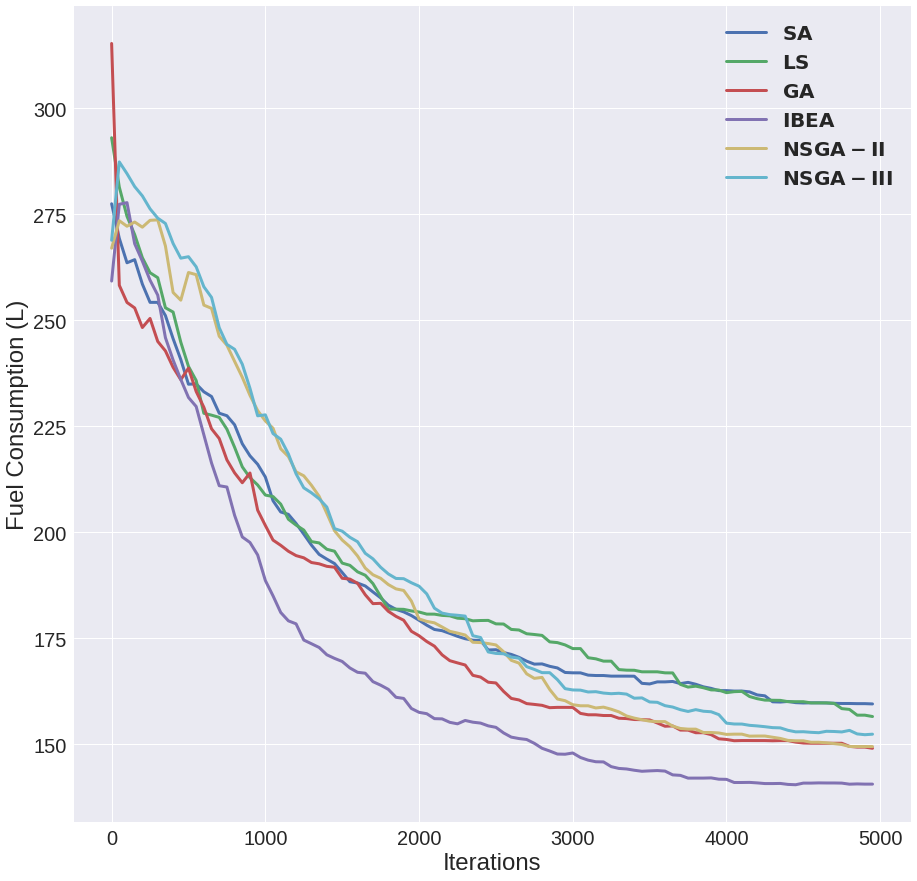

In [372]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.style.use("seaborn")
#legend_properties = {'weight':'bold','size':20}

plt.plot(np.mean(fitness_values_sa,axis=0),linewidth=3,label = r"$\bf{SA}$")
plt.plot(np.mean(fitness_values_ls,axis=0),linewidth=3,label = r"$\bf{LS}$")
plt.plot(np.mean(fitness_values_ga,axis=0),linewidth=3,label = r"$\bf{GA}$")
plt.plot(np.mean(fitness_values_ibea,axis=0) ,linewidth=3 ,label= r"$\bf{IBEA}$")
plt.plot(np.mean(fitness_values_nsga2,axis=0),linewidth=3,label = r"$\bf{NSGA-II}$")
plt.plot(np.mean(fitness_values_nsga3,axis=0),linewidth=3,label = r"$\bf{NSGA-III}$")
plt.xlabel("Iterations",fontsize=24)
plt.xticks(range(0,120,20),range(0,6000,1000))
plt.ylabel("Fuel Consumption (L)",fontsize=24)
plt.legend(fontsize=20)#,prop= legend_properties)
#plt.ylim(top=110)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


plt.show()

In [355]:
fig.savefig("{}/fuel_consumption_curve_UK50_2.pdf".format(dataPath))

In [7]:
compute_times_sa = [np.array(f) for f in sa_data.optimal_time ]
compute_times_ls =  [np.array(f) for f in ls_data.optimal_time ]
compute_times_ga =  [np.array(f) for f in ga_data.optimal_time ]
compute_times_nsga2 =  [np.array(f) for f in nsga2_data.optimal_time ]
compute_times_nsga3 =  [np.array(f) for f in nsga3_data.optimal_time ]
compute_times_ibea =  [np.array(f) for f in ibea_data.optimal_time ]
compute_times_ibea_adaptive =  [np.array(f) for f in ibea_data.optimal_time ]

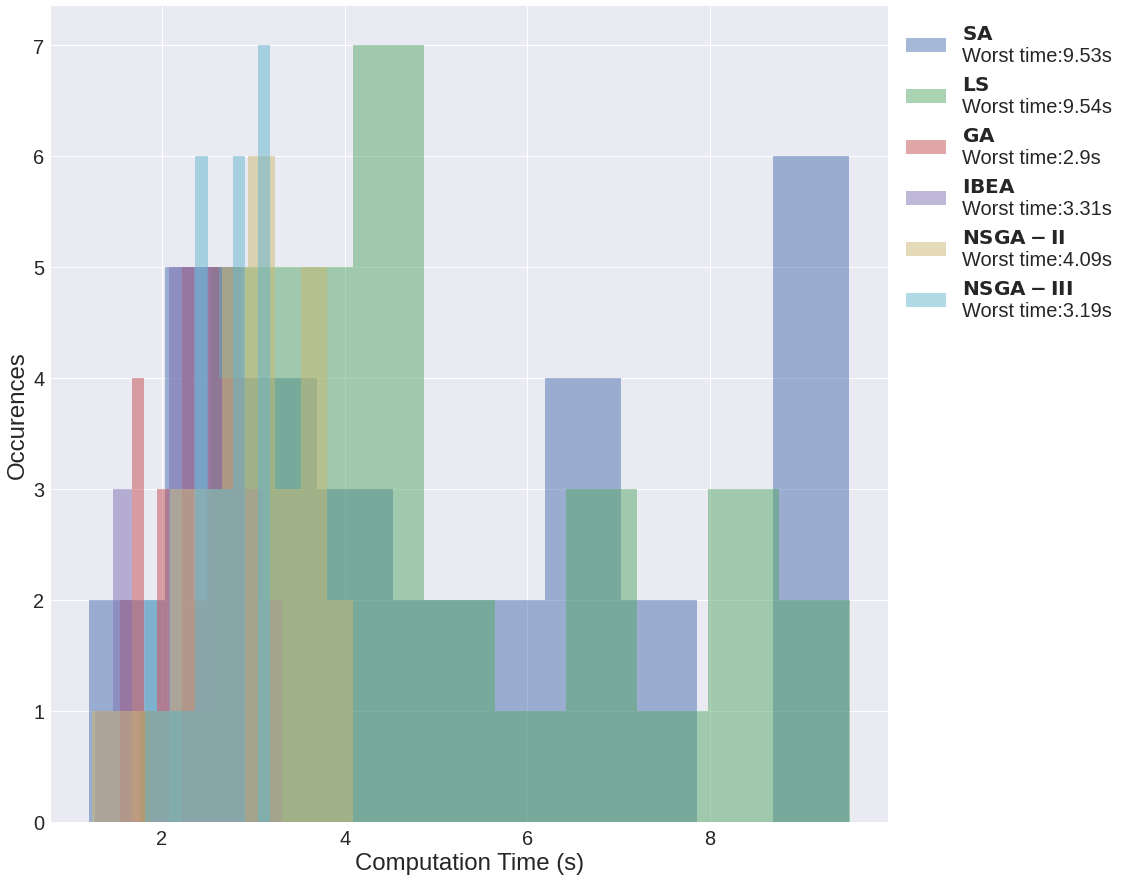

In [186]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.style.use("seaborn")

plt.hist(sa_data_optimal.optimal_time,label= r"$\bf{SA}$"+"\nWorst time:{test}s".format(test=round(max(sa_data_optimal.optimal_time),2)),alpha=0.5)
plt.hist(ls_data_optimal.optimal_time, label = r"$\bf{LS}$"+"\nWorst time:{test}s".format(test=round(max(ls_data_optimal.optimal_time),2)),alpha=0.5)
plt.hist(ga_data_optimal.optimal_time, label = r"$\bf{GA}$"+"\nWorst time:{test}s".format(test=round(max(ga_data_optimal.optimal_time),2)),alpha=0.5)
plt.hist(ibea_data_optimal.optimal_time, label= r"$\bf{IBEA}$"+"\nWorst time:{test}s".format(test=round(max(ibea_data_optimal.optimal_time),2)),alpha=0.5)
plt.hist(nsga2_data_optimal.optimal_time ,label = r"$\bf{NSGA-II}$"+"\nWorst time:{test}s".format(test=round(max(nsga2_data_optimal.optimal_time),2)),alpha=0.5)
plt.hist(nsga3_data_optimal.optimal_time ,label = r"$\bf{NSGA-III}$"+"\nWorst time:{test}s".format(test=round(max(nsga3_data_optimal.optimal_time),2)),alpha=0.5)
#plt.hist(ibea_adaptive[::5], label= r"$\bf{IBEA-Adaptive}$"+"\nWorst time:{test}s".format(test=round(max(ibea_data_optimal.optimal_time),2)),color=sns.color_palette("deep",10)[1],alpha=0.5)
plt.xlabel("Computation Time (s)",fontsize=24)
plt.ylabel("Occurences",fontsize=24)
plt.legend(fontsize=20,bbox_to_anchor=(1, 1))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

plt.show()

In [187]:
fig.savefig("{}/computation_time_to_optimal_sol_UK20_1.pdf".format(dataPath),bbox_inches='tight')

In [20]:
import numpy as np
import scipy.stats
import seaborn as sns

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def getTotalDriveTimesFromPaths(paths,timeMatrix):
    driveTimes = []
    
    for path in paths:
        driveTime = 0
        for route in path:
            for index in range(len(route)-1):
                driveTime += timeMatrix.iloc[route[index]][route[index+1]]

        driveTimes.append(driveTime/60)
            
    return driveTimes

def plot_confInterval_multiObj(datapoints, ax,markers):
    for data,marker in zip(datapoints,markers):
        fuel_consumptions =np.array( [x[0] for x in data.fitness_final])
        drive_times = np.array(data.optimal_time)#np.array([x[1] for x in data.fitness_final])
        mean_f0,min_f0,max_f0 = mean_confidence_interval(fuel_consumptions)
        mean_f1,min_f1,max_f1 = mean_confidence_interval(drive_times)
        
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],linestyle="--",linewidth=2,c="k",zorder=1)
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],linestyle="--",linewidth=2,c="k",zorder=1)
        
        plotlabel = r"$\bf{" + data.iloc[0].algorithm + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2))
        
        if data.iloc[0].algorithm != "IBEA-Adaptive":
            ax.scatter(x= mean_f0,y=mean_f1,label=plotlabel,s=200,marker=marker,zorder=2)
        else:
            ax.scatter(x= mean_f0,y=mean_f1,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return ax

def plot_confInterval_singleObj(datapoints, ax,markers,colors):
    for data,marker,color in zip(datapoints,markers,colors):
        fuel_consumptions = np.array(data.fuel_consumption_final)
        drive_times = np.array(data.optimal_time)##np.array(getTotalDriveTimesFromPaths(data.paths_final,time_matrix_here))
        mean_f0,min_f0,max_f0 = mean_confidence_interval(fuel_consumptions)
        mean_f1,min_f1,max_f1 = mean_confidence_interval(drive_times)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],linestyle="--",linewidth=2,c="k",zorder=1)
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],linestyle="--",linewidth=2,c="k",zorder=1)
        
        
        plotlabel = r"$\bf{" + data.iloc[0].algorithm + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2))
        
        
        ax.scatter(x= mean_f0,y=mean_f1,label=plotlabel,s=200,marker=marker,zorder=2)
    return ax

In [160]:
ibea_adaptive.algorithm = "IBEA-Adaptive"

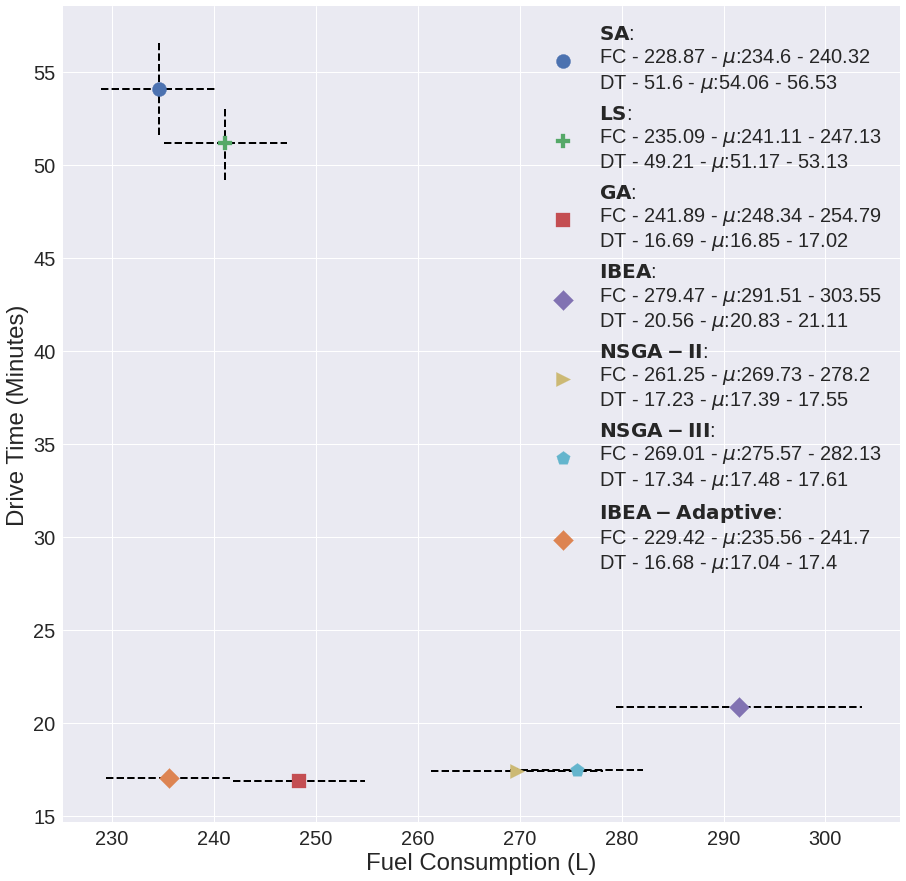

In [21]:
fig,ax = plt.subplots(1,1,figsize =(15,15))
colors=["orange","green","red","blue","olive","brown"]
plt.xlabel("Fuel Consumption (L)",fontsize=24)
plt.ylabel("Drive Time (Minutes)",fontsize=24)

markers = ["o","P","s","D",">","p","D"]
datapoints_singleobj = [sa_data,ls_data,ga_data]
datapoints_multiobj = [ibea_data,nsga2_data,nsga3_data,ibea_adaptive]

plot_confInterval_singleObj(datapoints_singleobj,ax,markers[:len(datapoints_singleobj)],colors[:len(datapoints_singleobj)])
plot_confInterval_multiObj(datapoints_multiobj,ax,markers[len(datapoints_singleobj):])
plt.legend(fontsize=20,bbox_to_anchor=(1, 1))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

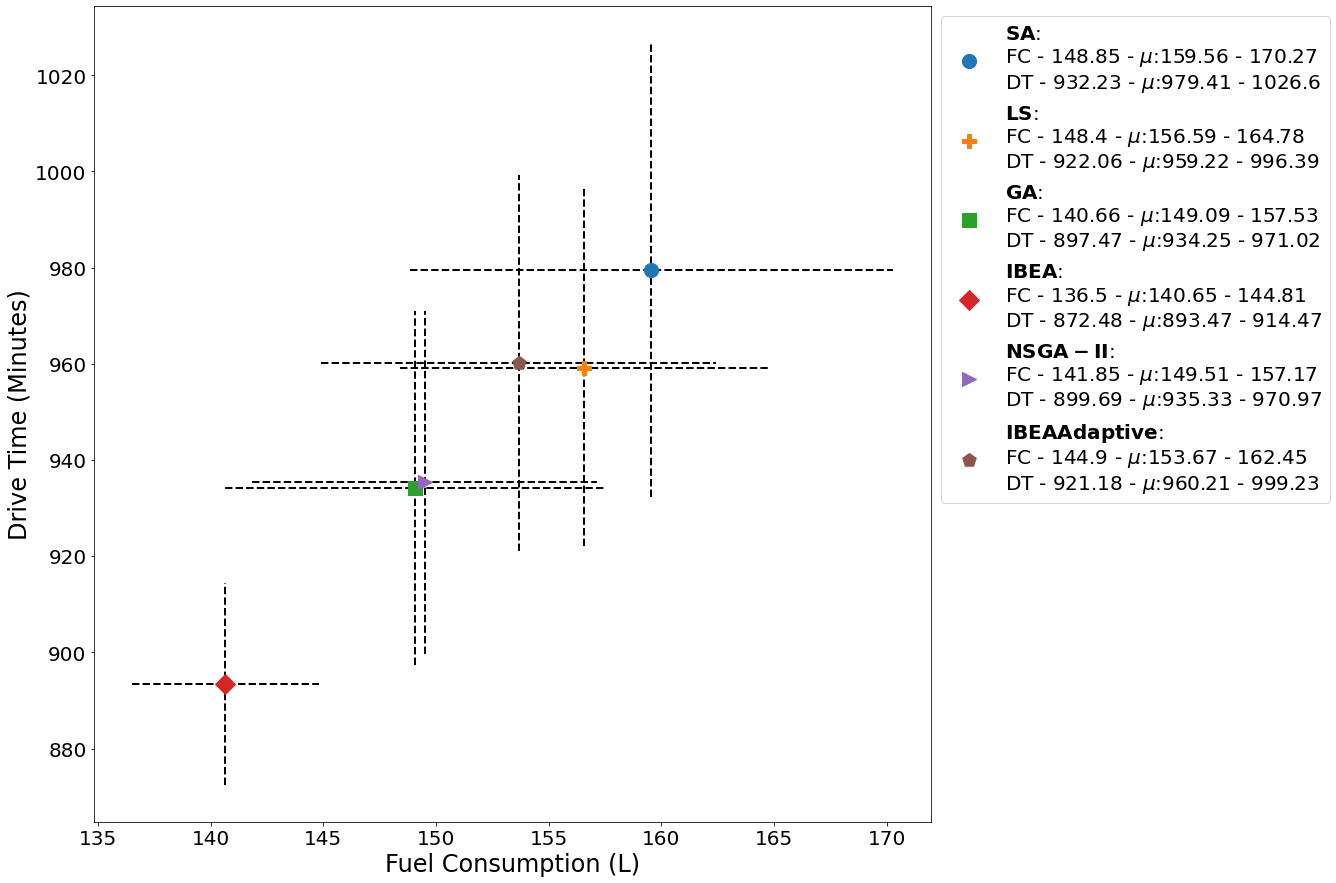

In [16]:
fig,ax = plt.subplots(1,1,figsize =(15,15))
colors=["orange","green","red","blue","olive","brown"]
plt.xlabel("Fuel Consumption (L)",fontsize=24)
plt.ylabel("Drive Time (Minutes)",fontsize=24)

markers = ["o","P","s","D",">","p"]
datapoints_singleobj = [sa_data_optimal,ls_data_optimal,ga_data_optimal]
datapoints_multiobj = [ibea_data_optimal,nsga2_data_optimal,ibea_adaptive_data_optimal]

plot_confInterval_singleObj(datapoints_singleobj,ax,markers[:len(datapoints_singleobj)],colors[:len(datapoints_singleobj)])
plot_confInterval_multiObj(datapoints_multiobj,ax,markers[len(datapoints_singleobj):],colors[len(datapoints_singleobj):])
plt.legend(fontsize=20,bbox_to_anchor=(1, 1))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

In [159]:
fig.savefig("{}/confidence_plotUK50_1_adaptive.pdf".format(dataPath),bbox_inches='tight')

In [20]:
import numpy as np
import scipy.stats
import seaborn as sns

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def getTotalDriveTimesFromPaths(paths,timeMatrix):
    driveTimes = []
    
    for path in paths:
        driveTime = 0
        for route in path:
            for index in range(len(route)-1):
                driveTime += timeMatrix.iloc[route[index]][route[index+1]]

        driveTimes.append(driveTime/60)
            
    return driveTimes

def plot_3d_multiObj(datapoints, ax,markers):
    for data,marker in zip(datapoints,markers):
        fuel_consumptions =np.array(data.fuel_consumption_final)#np.array( [x[0] for x in data.fitness_final])
        drive_times = np.array([x[1] for x in data.fitness_final])
        compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 = mean_confidence_interval(fuel_consumptions)
        mean_f1,min_f1,max_f1 = mean_confidence_interval(drive_times)
        mean_f2,min_f2,max_f2 = mean_confidence_interval(compute_times)
        
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],linestyle="--",linewidth=2,c="k",zorder=1)
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],linestyle="--",linewidth=2,c="k",zorder=1)
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],linestyle="--",linewidth=2,c="k",zorder=1)
        plotlabel = r"$\bf{" + data.iloc[0].algorithm + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        if data.iloc[0].algorithm != "IBEA-Adaptive":
            ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2)
        else:
            ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return ax

def plot_3d_singleObj(datapoints, ax,markers):
    for data,marker in zip(datapoints,markers):
        fuel_consumptions = np.array(data.fuel_consumption_final)
        drive_times = np.array(getTotalDriveTimesFromPaths(data.paths_final,time_matrix_here))
        compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 = mean_confidence_interval(fuel_consumptions)
        mean_f1,min_f1,max_f1 = mean_confidence_interval(drive_times)
        mean_f2,min_f2,max_f2 = mean_confidence_interval(compute_times)
        
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],linestyle="--",linewidth=2,c="k",zorder=1)
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],linestyle="--",linewidth=2,c="k",zorder=1)
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],linestyle="--",linewidth=2,c="k",zorder=1)
        
        plotlabel = r"$\bf{" + data.iloc[0].algorithm + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        
        
        ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2)
    return ax

In [21]:
ibea_adaptive.algorithm="IBEA-Adaptive"
#ibea_adaptive_2.algorithm="IBEA-Adaptive-2"

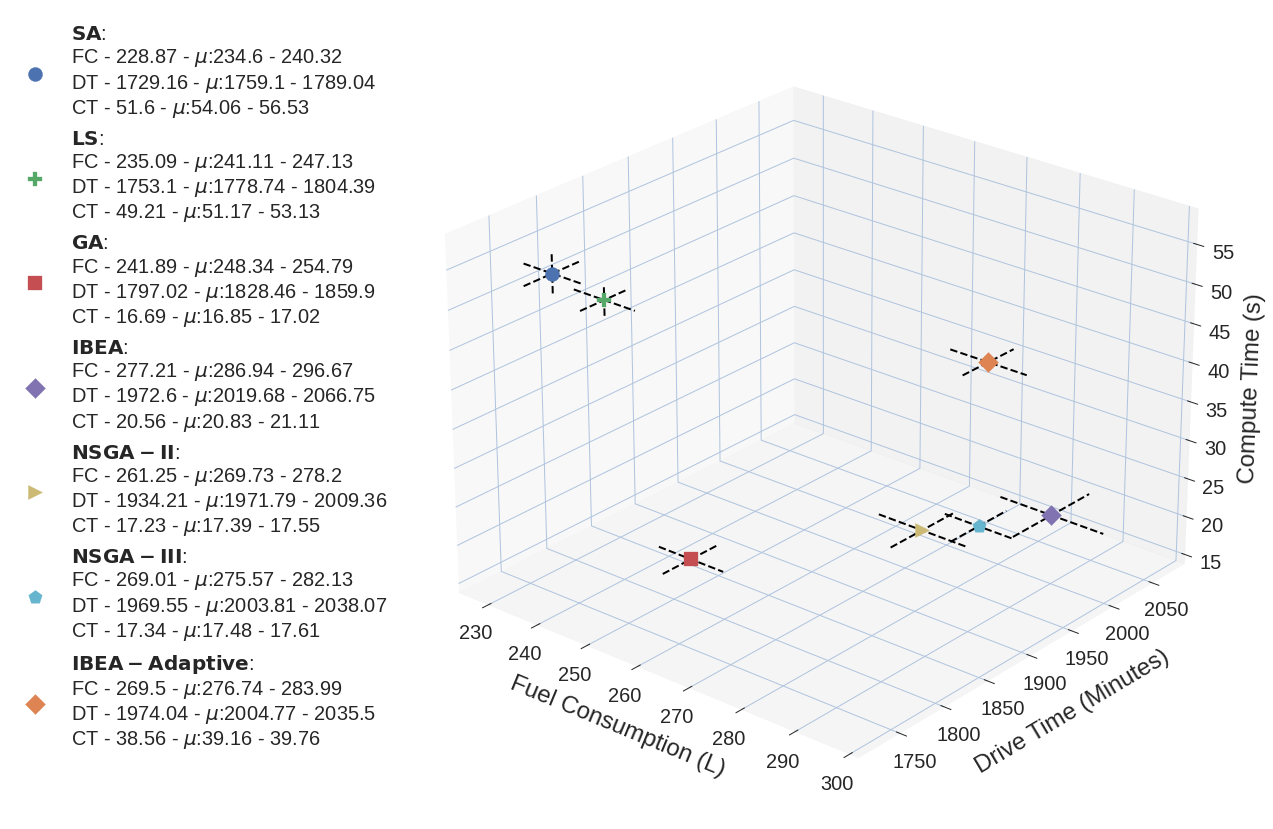

In [22]:
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
fig,ax = plt.subplots(1,1,figsize =(15,15),subplot_kw={"projection": "3d"})
colors=["orange","green","red","blue","olive","brown"]
plt.style.use("seaborn")
#plt.style.use('ggplot')
plt.rcParams['grid.color'] = "lightsteelblue"
markers = ["o","P","s","D",">","p","D"]
datapoints_singleobj = [sa_data,ls_data,ga_data]
datapoints_multiobj = [ibea_data,nsga2_data,nsga3_data,ibea_adaptive]

plot_3d_singleObj(datapoints_singleobj,ax,markers[:len(datapoints_singleobj)])
plot_3d_multiObj(datapoints_multiobj,ax,markers[len(datapoints_singleobj):])
plt.legend(fontsize=20,bbox_to_anchor=(0, 1))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.zaxis.set_tick_params(labelsize=20)

ax.set_xlabel("Fuel Consumption (L)",fontsize=24,labelpad=20)
ax.set_ylabel("Drive Time (Minutes)",fontsize=24,labelpad=24)
ax.set_zlabel("Compute Time (s)",fontsize=24,labelpad=14)
ax.set_facecolor('white')
ax.view_init(elev=25,azim=-50)
#plt.tight_layout(pad=2)
ax.grid()
plt.show()

In [25]:
dataPath

'../logs/UK20_1_Logs/'

In [23]:
fig.savefig("{}/confidence_plot_3d_50_pop.pdf".format(dataPath),bbox_inches='tight')

In [20]:

def create_DF_dict(resultData):
    results = []
    for data in resultData:
        if data.algorithm.iloc[0] in ["SA","LS","GA"]:
            fuel_consumptions = np.array(data.fuel_consumption_final)
            drive_times = np.array(getTotalDriveTimesFromPaths(data.paths_final,time_matrix_here))
        else:
            fuel_consumptions =np.array( [x[0] for x in data.fitness_final])
            drive_times = np.array([x[1] for x in data.fitness_final])
            
        parameters = {}
        for paramName in ["Mutation","Crossover"]:
            if paramName.lower() in data:
                parameters[paramName] = data[paramName.lower()].iloc[0]
    
        mean_f0,min_f0,max_f0 = mean_confidence_interval(fuel_consumptions)
        mean_f1,min_f1,max_f1 = mean_confidence_interval(drive_times)

        di = {"Algorithm":data.algorithm.iloc[0],"Parameter Group":int(data.paramGroup.iloc[0]),**parameters,
              "Fuel Consumption Mean": mean_f0,"Fuel Consumption Std":np.std(fuel_consumptions),
              "Total Drive Time Mean":mean_f1,"Total Drive Time Std":np.std(drive_times)}
        results.append(di)
    return results


# UK_20_1

In [59]:
best_combined = [sa_data_optimal,ls_data_optimal,ga_data_optimal,nsga2_data_optimal,nsga3_data_optimal,ibea_data_optimal]
a = pd.DataFrame(create_DF_dict(best_combined))
a.sort_values(by = ["Fuel Consumption Mean","Total Drive Time Mean"],ignore_index=True,inplace=True)

a = a[["Algorithm","Parameter Group","Mutation","Crossover","Fuel Consumption Mean","Fuel Consumption Std","Total Drive Time Mean","Total Drive Time Std"]]


text_file = open("{}/optimal_parameters_latex_UK20_3.txt".format(dataPath), "wt")
text_file.truncate(0)
n = text_file.write(a.to_latex())
text_file.close()
a

,Algorithm,Parameter Group,Mutation,Crossover,Fuel Consumption Mean,Fuel Consumption Std,Total Drive Time Mean,Total Drive Time Std
0,NSGA-III,41,0.9,0.35,48.936111,5.417407,415.193889,28.256348
1,NSGA-II,33,0.7,0.65,48.975022,4.681595,414.712778,26.168383
2,IBEA,40,0.9,0.20,49.583738,5.024197,416.757222,22.053599
3,GA,37,0.8,0.50,52.338119,5.904486,421.557778,23.756203
4,SA,24,0.9,NaN,53.128724,6.674067,427.077778,27.866891
5,LS,6,0.7,NaN,53.421563,7.562976,431.760000,32.035772


In [7]:
def getDriveTimesForRoutes(paths,timeMatrix,startNodes):
    routeTimes = []
    
    for path in paths:
        driveTimes = {}
        for start in startNodes:
            driveTimes[start] = 0
        
        
        for route in path:
            currentStart = route[0]
            #driveTimes[currentStart] = 0
            driveTime = 0
            for index in range(len(route)-1):
                driveTimes[currentStart]  += timeMatrix.iloc[route[index]][route[index+1]]/60
        
        for start in startNodes:
            if not start in driveTimes.keys():
                driveTimes[start] = 0
            
        
        routeTimes.append(driveTimes)
    return routeTimes


In [74]:

startNodes = [0,6,10,15,21,35,40]
vehicle_driveTimes_ibea = getDriveTimesForRoutes(ibea_10_adap.paths_final,time_matrix_here,startNodes)
vehicle_driveTimes_sa = getDriveTimesForRoutes(sa_data.paths_final,time_matrix_here,startNodes)

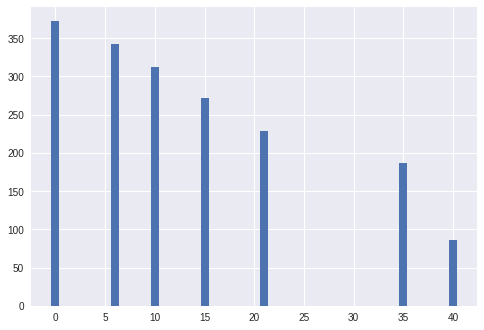

In [75]:
driveTimes_list_ibea = np.array([sorted(list(vehicle.values()),reverse=True) for vehicle in vehicle_driveTimes_ibea])
driveTimes_list_sa = np.array([sorted(list(vehicle.values()),reverse=True) for vehicle in vehicle_driveTimes_sa])
#plt.bar(startNodes,np.mean(driveTimes_list_ibea,axis=0))
#plt.xticks([1,2,3,4],labels=[1,2,3,4])
#plt.show()

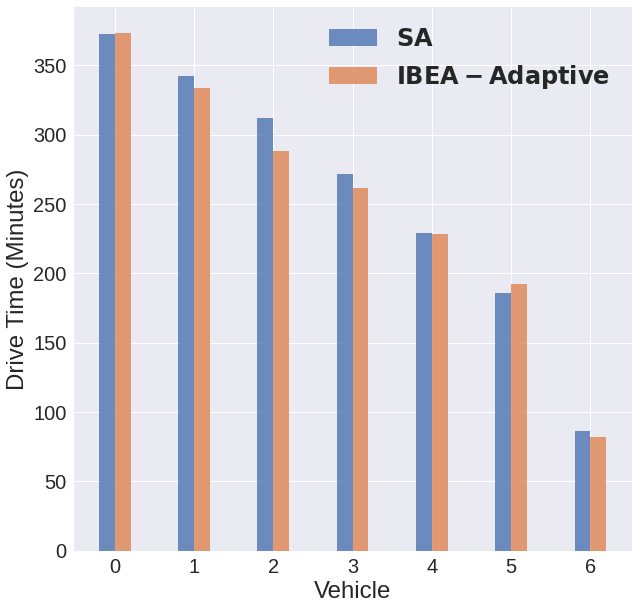

In [76]:
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.bar(np.array(range(0,len(vehicle_driveTimes_sa[0].keys())))-0.1,np.mean(driveTimes_list_ibea,axis=0),width=0.2,alpha=0.8,label=r"$\bf{SA}$",align="center")
plt.bar(np.array(range(0,len(vehicle_driveTimes_ibea[0].keys())))+0.1,np.mean(driveTimes_list_sa,axis=0),width=0.2,alpha=0.8,label=r"$\bf{IBEA-Adaptive}$",align="center",color=sns.color_palette("deep",10)[1])
plt.xticks(range(0,len(startNodes)),labels=range(0,len(startNodes)))
plt.legend(fontsize=24,bbox_to_anchor=(1,1))
ax.xaxis.set_tick_params(labelsize=20)#fontsize=20,
ax.yaxis.set_tick_params(labelsize=20)
plt.ylabel("Drive Time (Minutes)",fontsize=24)
plt.xlabel("Vehicle",fontsize=24)
#plt.tight_layout(pad=1)
plt.show()


In [77]:
fig.savefig("{}/driveTime_split_UK50_1_ibea.pdf".format(dataPath))#,bbox_inches='tight')

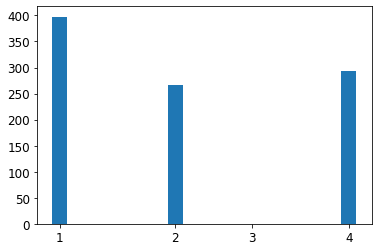

In [712]:
plt.bar(vehicle_driveTimes_maxdrivetime[0].keys(),list(vehicle_driveTimes_maxdrivetime[0].values()))
plt.xticks(startNodes,labels=[1,2,3,4])
plt.show()

In [713]:
driveTimes_list = np.array([sorted(list(vehicle.values()),reverse=True) for vehicle in vehicle_driveTimes])
driveTimes_list_max_drivetime = np.array([sorted(list(vehicle.values()),reverse=True) for vehicle in vehicle_driveTimes_maxdrivetime])

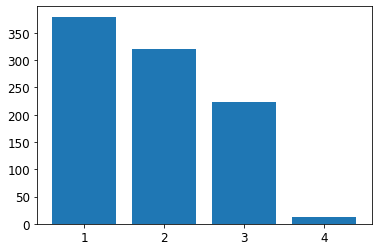

In [714]:
plt.bar([1,2,3,4],np.mean(driveTimes_list,axis=0))
plt.xticks([1,2,3,4],labels=[1,2,3,4])
plt.show()

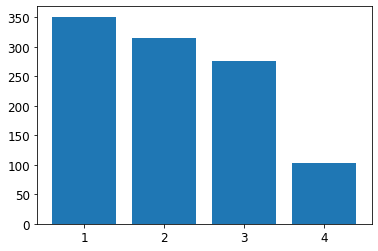

In [715]:

plt.bar([1,2,3,4],np.mean(driveTimes_list_max_drivetime,axis=0))
plt.xticks([1,2,3,4])#,labels=[1,2,3,4])
plt.show()

,Source,SS,DF,MS,F,p-unc,np2
0,algorithm,3.559852e+06,5,711970.410126,71.965068,1.533206e-40,0.674051
1,Within,1.721430e+06,174,9893.277777,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


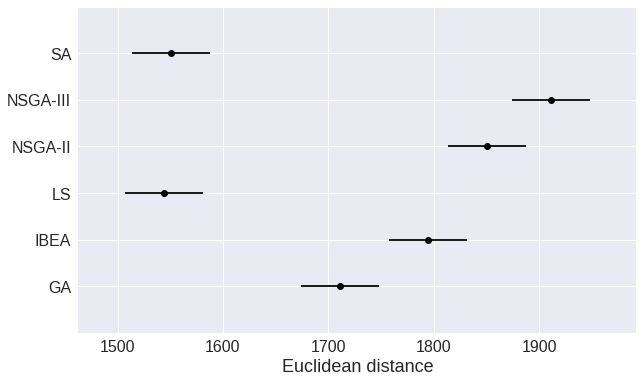

In [308]:
test = pd.concat([sa_data,ls_data,ga_data,nsga2_data,nsga3_data,ibea_data])

display(anova_test(test,'IGD_final','algorithm'))
_,figure,_ = anova_plot(test,'IGD_final','algorithm')

,Source,SS,DF,MS,F,p-unc,np2
0,algorithm,7.781853e+04,5,15563.706889,1.863677,0.103036,0.050832
1,Within,1.453087e+06,174,8351.075970,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


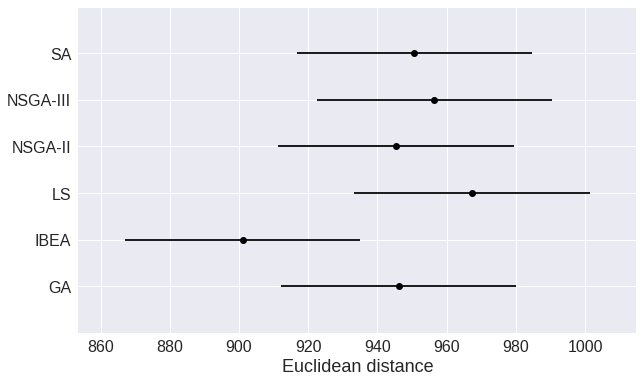

In [76]:
test = pd.concat([sa_data_optimal,ls_data_optimal,ga_data_optimal,nsga2_data_optimal,nsga3_data_optimal,ibea_data_optimal])

display(anova_test(test,'IGD_final','algorithm'))
_,figure,_ = anova_plot(test,'IGD_final','algorithm')

In [309]:
figure.savefig("{}/anovaplot.pdf".format(dataPath))

# Compares the three best tested parameters for algorithms

In [60]:
allData_optimal = pd.concat([sa_optimal,ls_optimal,ga_optimal,nsga2_optimal,nsga3_optimal,hype_optimal],axis=0)

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,5.434980e+06,2,2.717490e+06,0.830664,0.437461,0.009351
1,Within,5.757779e+08,176,3.271465e+06,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,algorithm,7.121867e+07,5,1.424373e+07,4.831753,0.000367,0.122535
1,Within,5.099942e+08,173,2.947944e+06,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x1080 with 0 Axes>

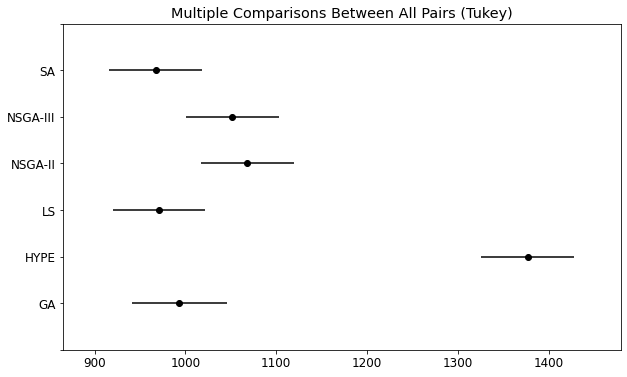

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
GA,HYPE,383.8136,0.001,280.6344,486.9929,1.0
HYPE,LS,-406.1707,0.001,-508.4718,-303.8695,1.0
HYPE,NSGA-II,-309.1216,0.001,-411.4227,-206.8204,1.0
HYPE,NSGA-III,-325.4672,0.001,-427.7684,-223.1661,1.0
HYPE,SA,-409.8408,0.001,-512.1419,-307.5396,1.0


In [61]:
display(anova_test(allData_optimal,'maxDriveTimes_final','mutation'))
display(anova_test(allData_optimal,'maxDriveTimes_final','algorithm'))
anova_plot(allData_optimal,'IGD_final','algorithm')

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,4.582110e+06,1,4.582110e+06,1.143283,0.286416,0.006418
1,Within,7.093899e+08,177,4.007853e+06,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,algorithm,1.000755e+08,5,2.001510e+07,5.640384,0.000076,0.140167
1,Within,6.138965e+08,173,3.548535e+06,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x1080 with 0 Axes>

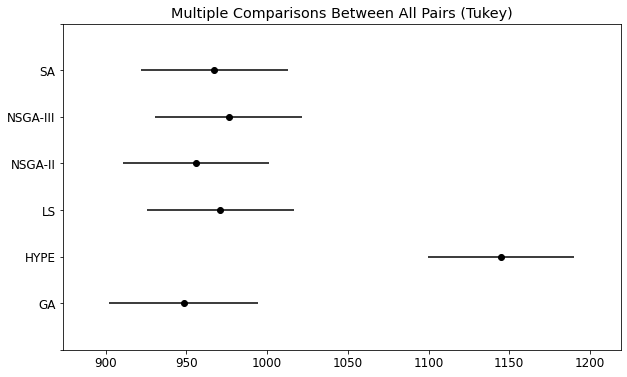

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
GA,HYPE,196.5087,0.001,104.8290,288.1885,1.0
HYPE,LS,-173.9145,0.001,-264.8140,-83.0150,1.0
HYPE,NSGA-II,-188.8621,0.001,-279.7616,-97.9626,1.0
HYPE,NSGA-III,-168.7930,0.001,-259.6925,-77.8936,1.0
HYPE,SA,-177.5846,0.001,-268.4841,-86.6851,1.0


In [44]:
display(anova_test(allData_optimal,'maxDriveTimes_final','mutation'))
display(anova_test(allData_optimal,'maxDriveTimes_final','algorithm'))
anova_plot(allData_optimal,'IGD_final','algorithm')

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,4.582110e+06,1,4.582110e+06,1.143283,0.286416,0.006418
1,Within,7.093899e+08,177,4.007853e+06,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,algorithm,1.000755e+08,5,2.001510e+07,5.640384,0.000076,0.140167
1,Within,6.138965e+08,173,3.548535e+06,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x1080 with 0 Axes>

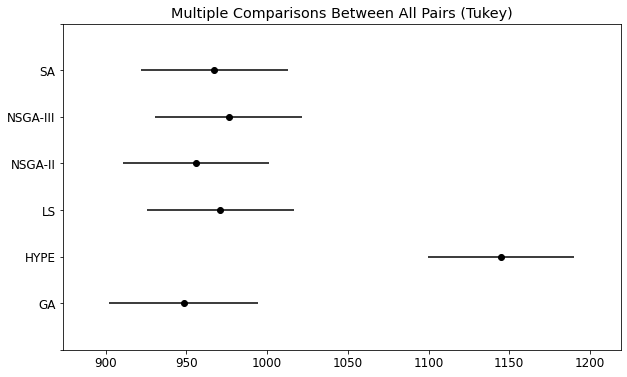

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
GA,HYPE,196.5087,0.001,104.8290,288.1885,1.0
HYPE,LS,-173.9145,0.001,-264.8140,-83.0150,1.0
HYPE,NSGA-II,-188.8621,0.001,-279.7616,-97.9626,1.0
HYPE,NSGA-III,-168.7930,0.001,-259.6925,-77.8936,1.0
HYPE,SA,-177.5846,0.001,-268.4841,-86.6851,1.0


In [46]:
display(anova_test(allData_optimal,'maxDriveTimes_final','mutation'))
display(anova_test(allData_optimal,'maxDriveTimes_final','algorithm'))
anova_plot(allData_optimal,'IGD_final','algorithm')

In [229]:
all_norm = allData_optimal_test.copy()
mean = all_norm.fitness_final.mean()
std = all_norm.fitness_final.std()
all_norm.fitness_final = (all_norm.fitness_final-mean)/std
all_norm

,paramGroup,mutation,alpha,algorithm,fitness,fuel_consumption,optimal_time,maxDriveTimes,violation,paths,fitness_final,fuel_consumption_final,maxDriveTimes_final,violation_final,paths_final,crossover
1050,35.0,0.9,0.9999,SA,"[18046.33607508727, 10493.228855766933, 1702.8...","[321.33607508726993, 329.2288557669318, 285.82...",4.545439,"[42925, 35364, 26617, 26617, 26617, 22667, 217...","[-17725, -10164, -1417, -1417, -1417, 0, 0, 0,...","[[6, 1, 17, 9, 18, 13, 5], [15, 16, 11, 14, 12...",-0.484220,145.549477,24245.0,0.0,"[[6, 1, 17, 9, 18, 13, 5], [15, 16, 11, 14, 12...",NaN
1051,35.0,0.9,0.9999,SA,"[15006.189518087112, 10439.993519972875, 8780....","[309.1895180871117, 266.99351997287476, 290.02...",3.792712,"[39897, 35373, 33690, 33339, 29889, 28563, 285...","[-14697, -10173, -8490, -8139, -4689, -3363, -...","[[10, 9, 4], [15, 13, 7, 19, 12, 14, 16, 11, 2...",1.258359,189.928206,24675.0,0.0,"[[10, 9, 4], [15, 13, 7, 19, 12, 14, 16, 11, 2...",NaN
1052,35.0,0.9,0.9999,SA,"[5491.465279659051, 225.56956273521712, 210.35...","[269.46527965905057, 225.56956273521712, 210.3...",2.067353,"[30422, 24730, 24730, 24564, 24564, 23770, 237...","[-5222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[15, 12, 14, 16, 3, 18, 13, 5], [6, 1, 17, 9,...",-0.111519,155.041144,23195.0,0.0,"[[15, 12, 14, 16, 3, 18, 13, 5], [6, 1, 17, 9,...",NaN
1053,35.0,0.9,0.9999,SA,"[4367.485038862146, 4358.5250089241545, 2430.8...","[248.48503886214655, 239.52500892415406, 240.8...",4.282049,"[29319, 29319, 27390, 26607, 22830, 22830, 228...","[-4119, -4119, -2190, -1468, 0, 0, 0, 0, 0, 0,...","[[0, 8, 16, 11, 12, 14, 7, 19, 5], [6, 1, 3, 1...",-0.220981,152.253458,24620.0,0.0,"[[0, 8, 16, 11, 12, 14, 7, 19, 5], [6, 1, 3, 1...",NaN
1054,35.0,0.9,0.9999,SA,"[1254.2408383944141, 771.4662344890783, 237.56...","[286.2408383944141, 254.4662344890783, 237.566...",2.982390,"[26168, 25717, 23144, 23144, 23028, 23028, 212...","[-968, -517, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[15, 16, 11, 12, 14, 19, 7, 5], [0, 8, 1, 17,...",-0.712416,139.737928,22209.0,0.0,"[[15, 16, 11, 12, 14, 19, 7, 5], [0, 8, 1, 17,...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,40.0,0.9,NaN,HYPE,"[340.8648087358888, 309.09588378066815, 317.95...","[340.8648087358888, 309.09588378066815, 317.95...",4.433278,"[64943, 43634, 30080, 28600, 28600, 28600, 286...","[-39764, -18434, -4880, -3469, -3469, -3469, -...","[[0, 3, 18, 13, 19, 12, 14, 7, 5], [6, 11, 16,...",0.478461,170.066324,25193.0,0.0,"[[0, 3, 18, 13, 19, 12, 14, 7, 5], [6, 11, 16,...",0.2
1226,40.0,0.9,NaN,HYPE,"[397.50473439269564, 300.98701683068913, 304.4...","[397.50473439269564, 300.98701683068913, 304.4...",3.622356,"[71197, 38723, 38250, 35703, 30897, 30283, 298...","[-46190, -13523, -13050, -10807, -5697, -5083,...","[[6, 11, 16, 12, 14, 19, 13, 7, 5], [0, 3, 1, ...",0.043003,158.976404,24707.0,0.0,"[[6, 11, 16, 12, 14, 19, 13, 7, 5], [0, 3, 1, ...",0.2
1227,40.0,0.9,NaN,HYPE,"[335.6349045621991, 335.23958303931795, 335.23...","[335.6349045621991, 335.23958303931795, 335.23...",2.778969,"[64883, 41631, 41631, 29844, 27874, 23399, 233...","[-39683, -16431, -16431, -4644, -2674, 0, 0, 0...","[[15, 3, 18, 13, 7, 19, 5], [6, 1, 17, 9, 4], ...",-1.086751,130.204641,21298.0,0.0,"[[15, 3, 18, 13, 7, 19, 5], [6, 1, 17, 9, 4], ...",0.2
1228,40.0,0.9,NaN,HYPE,"[328.8403899834197, 320.0921476440393, 320.092...","[328.8403899834197, 320.0921476440393, 320.092...",1.186200,"[57462, 30055, 30055, 30055, 29908, 29908, 266...","[-32455, -4855, -4855, -4855, -4708, -4708, -1...","[[15, 19, 7, 12, 14, 16, 11, 2], [0, 8, 17, 9,...",-0.449513,146.433348,22560.0,0.0,"[[15, 19, 7, 12, 14, 16, 11, 2], [0, 8, 17, 9,...",0.2


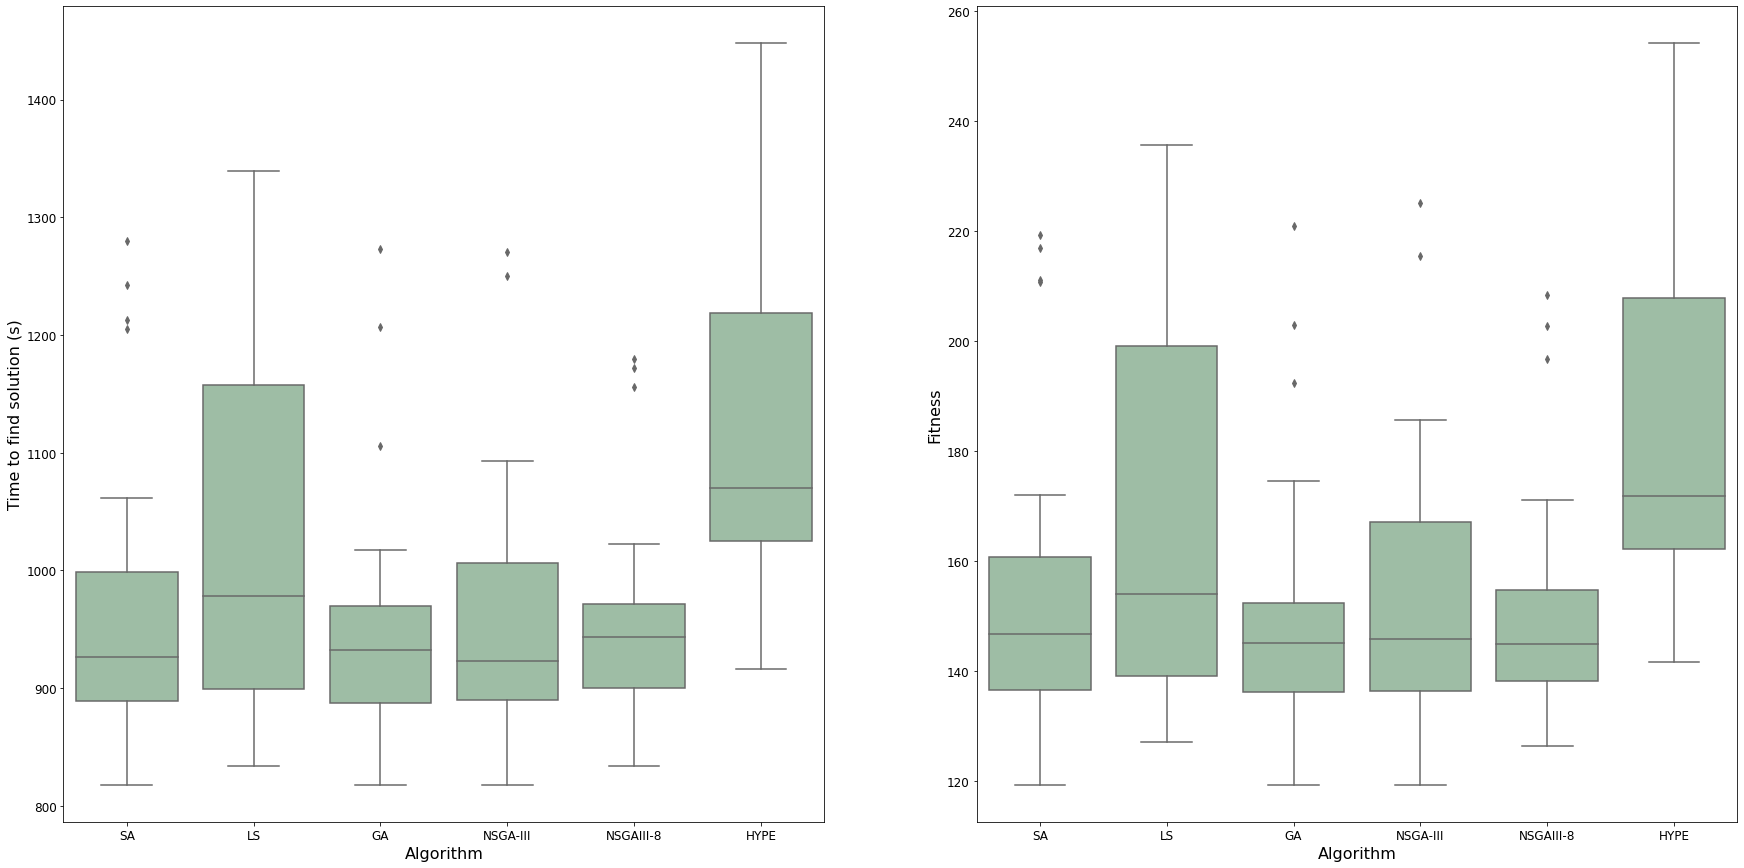

In [20]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(30,15))



sns.boxplot(x='algorithm', y='IGD_final', data=test, color='#99c2a2',ax = axs[0])
sns.boxplot(x='algorithm', y='fuel_consumption_final', data=test, color='#99c2a2',ax = axs[1])
axs[0].set_xlabel("Algorithm",fontsize=16)
axs[0].set_ylabel("Time to find solution (s)",fontsize = 16)

axs[1].set_xlabel("Algorithm",fontsize=16)
axs[1].set_ylabel("Fitness",fontsize=16)
plt.show()

In [208]:
allData_optimal_test = pd.concat([sa_optimal,ls_optimal,ga_optimal,nsga2_optimal,nsga2_test_optimal,nsga3_optimal,hype_optimal],axis=0)

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,2092.327252,4,523.081813,0.805499,0.521892,0.005145
1,Within,404568.845120,623,649.388194,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,algorithm,8687.091541,6,1447.848590,2.259227,0.036386,0.021362
1,Within,397974.080831,621,640.860034,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x1080 with 0 Axes>

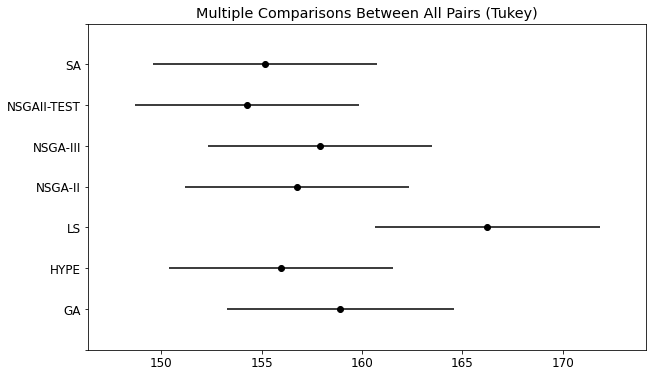

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
LS,NSGAII-TEST,-11.988,0.0261,-23.1508,-0.8251,1.0


In [232]:
display(anova_test(allData_optimal_test,'fitness_final','mutation'))#nsga2_test_optimal
display(anova_test(allData_optimal_test,'fitness_final','algorithm'))
anova_plot(allData_optimal_test,'fitness_final','algorithm')